In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image
import hashlib

In [ ]:
zip_file_path = '/content/data.zip'

In [ ]:
extracted_dir = '/content/'

In [ ]:
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"The zip file '{zip_file_path}' does not exist.")

In [ ]:
#Setting up directories
data_dir = '/content/Data/'

#Extracting and loading the data
with zipfile.ZipFile('/content/data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
# Load and preprocess the dataset
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'Data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    'Data/valid',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'Data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes (3 types of cancer + 1 normal)
])

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=10
)

Epoch 1/10
19/19 [==============================] - 37s 2s/step - loss: 1.3349 - accuracy: 0.3907 - val_loss: 1.0011 - val_accuracy: 0.5469
Epoch 2/10
19/19 [==============================] - 51s 2s/step - loss: 0.8025 - accuracy: 0.6661 - val_loss: 0.7637 - val_accuracy: 0.6562
Epoch 3/10
19/19 [==============================] - 38s 2s/step - loss: 0.5612 - accuracy: 0.7952 - val_loss: 0.5732 - val_accuracy: 0.7656
Epoch 4/10
19/19 [==============================] - 38s 2s/step - loss: 0.3771 - accuracy: 0.8657 - val_loss: 0.5600 - val_accuracy: 0.8125
Epoch 5/10
19/19 [==============================] - 37s 2s/step - loss: 0.2671 - accuracy: 0.9036 - val_loss: 0.6466 - val_accuracy: 0.7500
Epoch 6/10
19/19 [==============================] - 37s 2s/step - loss: 0.1946 - accuracy: 0.9441 - val_loss: 0.4905 - val_accuracy: 0.8438
Epoch 7/10
19/19 [==============================] - 35s 2s/step - loss: 0.1643 - accuracy: 0.9466 - val_loss: 0.4562 - val_accuracy: 0.7969
Epoch 8/10
19/19 [==

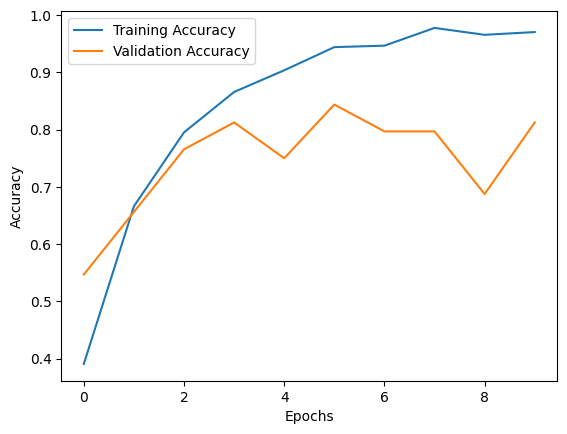

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_acc:.2f}')

9/9 [==============================] - 5s 477ms/step - loss: 2.9588 - accuracy: 0.4792
Test Accuracy: 0.48


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=128, step=16),
                         (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='hyperparam_tuning',
                     project_name='cancer_classification')

tuner.search(train_generator, epochs=10, validation_data=valid_generator)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of filters in the first convolutional layer is {best_hps.get('conv_1_filter')},
the optimal learning rate is {best_hps.get('learning_rate')},
and the optimal number of units in the dense layer is {best_hps.get('dense_units')}.
""")